In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
#import statements
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from music21 import converter, instrument, note, chord, stream, duration
import glob
import os
from itertools import chain
import copy
import numpy as np
from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from keras.layers import CuDNNLSTM,Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

In [7]:

def data_extractor(directory):
  """
    Summary:
    Function converts midi files to metadata and appends nested metadata lists into one large list
    composed of all the songs in the dataset.

    Parameters:
    directory: String representation of directroy where midi files are located

    Returns:
    list: sequential midi file metadata 
   """
  data = []
  for file in glob.glob(directory):
          mid = converter.parse(file)
          notes_to_parse = None
          
          try: 
              s2 = instrument.partitionByInstrument(mid)
              notes_to_parse = s2.parts[0].recurse() 
                 
          except: 
              notes_to_parse = mid.flat.notes

          for element in notes_to_parse:
              if isinstance(element, note.Note):
                  data.append(str(element.pitch))
              elif isinstance(element, chord.Chord):
                  data.append('.'.join(str(n) for n in element.normalOrder))
  return data


  

In [8]:
data = data_extractor("/content/drive/MyDrive/midi_files/*.mid")
unique = len(list(set(data)))

(array([70344., 41703., 29599., 11078., 11534.,  3195.,   933.,   616.,
          384.,   109.]),
 array([  0. ,  37.5,  75. , 112.5, 150. , 187.5, 225. , 262.5, 300. ,
        337.5, 375. ]),
 <a list of 10 Patch objects>)

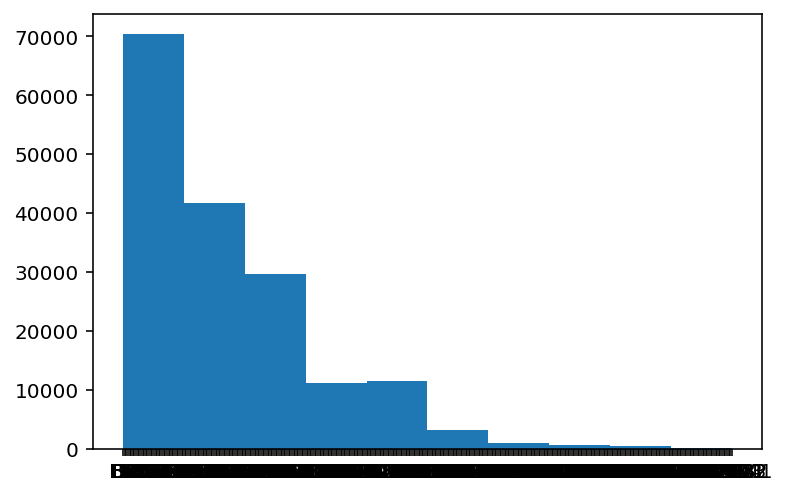

In [ ]:
plt.hist(data)

In [ ]:
def make_dict(data, to_int = True):
  """
    Summary:
    Function maps either midi metadata into integers and integers back into midi metadata.

    Parameters:
    data: the data to be used as keys in a dictionary
    to_int: if the function maps from midi to int or int to midi
    
    Returns:
    dictionary: dictioanry with keys from data argument 
   """

  unnested_data = data
  data_set = sorted(set(unnested_data))
  if to_int:
    notes_to_ints = dict((note,number/unique) for number, note in enumerate(data_set))
  else:
    notes_to_ints = dict((number,note) for number, note in enumerate(data_set))

  return notes_to_ints
unique_vals = list(set(list(make_dict(data).values())))

In [ ]:
def str_to_int():
  """
  Summary:
  Function maps original midi list data into the correspondong integer value from the defined ictionary

  Returns:
  list: integers corresponding to midi metadata 
  """
  mapper = make_dict(data)
  mapped_sequence = copy.deepcopy(data)
  for i in range(len(mapped_sequence)):
      mapped_sequence[i] = mapper[mapped_sequence[i]]
      
  return mapped_sequence

In [ ]:
def int_to_string(output):
  """
  Summary:
  Function maps original integers values back into the midi metadata

  Parameters:
  output: model output list that need converting back into midi metadata

  Returns:
  list: midi metadata
  """
  output = [int(val*unique) for val in output]
  mapper = make_dict(data,to_int = False)
  mapped_sequence = output
  for i in range(len(mapped_sequence)):
      mapped_sequence[i] = mapper[mapped_sequence[i]]
      
  return mapped_sequence

In [ ]:
def to_midi(metadata):
  """
  Summary:
  Takes midi metadata and converts it to a Music21 stream. The stream can then easily be converted into a midi file.

  Parameters:
  metadata: midi metadata (notes,chords,offsets,durations)

  Returns:
  list: Music21 stream object
  """
  offsets = 0
  s = stream.Stream()
  for notes in metadata:
    if notes[0].isalpha():
      n = note.Note(notes)
      s.insert(offsets,n)
      offsets += 0.25
    else:
      chords = list(map(int,notes.split('.')))
      c = chord.Chord(chords)
      s.insert(offsets,c)
      offsets += 0.25
  return s
#to_midi(int_to_string(str_to_int())).write("midi", "s.mid")


In [ ]:
from numpy import argmax
def one_hot_encode(vector, all_values = unique_vals):
  encoded_vectors = []
  int_to_index = dict((c, i) for i, c in enumerate(all_values))
  
  for i in vector:
    zero = [0]*(len(all_values)-1)
    zero.insert(int_to_index[i],1)
    encoded_vectors.append(zero)
  
  return encoded_vectors

In [ ]:
from numpy import argmax
def one_hot_decode(vector, all_values = unique_vals):
  decoded_vector = []
  all_values = unique_vals
  index_to_int = dict((i, c) for i, c in enumerate(all_values))
  for vec in vector:
    decoded_vector.append(index_to_int[argmax(vec)])
  return decoded_vector

In [ ]:
def test_data_pipeline():
  data = data_extractor("/content/drive/MyDrive/midi_short/*.mid")
  unique_vals = list(set(list(make_dict(data).values())))
  unique = len(list(set(data)))
  seg = make_segments()
  note_list = seg[0][1].tolist()
  
  if int_to_string(note_list) == data[1:len(seg[0][1])+1]:
    return True
  else:
    return False

In [ ]:
import keras.utils

def make_segments(seq_length = 25):
  if test_data_pipeline:
    normal_data = str_to_int()
    input_seq = []
    output_seq = []
    for i in range(0,len(normal_data) - seq_length,1):
      input_seq.append([normal_data[i:i+seq_length]])
      output_seq.append(normal_data[seq_length + i])
    
    input_seq = np.stack(arr[0] for arr in input_seq)
    output_seq = np.array(one_hot_encode(output_seq))
    else:
      print("Pipeline Broken")
    return input_seq, output_seq
model_data = make_segments()

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(model_data[0], model_data[1],test_size=0.2)

In [ ]:
model = Sequential()
model.add(CuDNNLSTM(512,input_shape=(25, 1),return_sequences=False))
model.add(Dense(256))
model.add(Dropout(0.5))
model.add(Dense(unique, activation = 'softmax'))



model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy']
)

In [ ]:
history = model.fit(X_train,y_train,epochs=1000,validation_split = 0.2)

Epoch 1/1000
3390/3390 [==============================] - 20s 6ms/step - loss: 4.6351 - accuracy: 0.0253 - val_loss: 4.5807 - val_accuracy: 0.0294
Epoch 2/1000
3390/3390 [==============================] - 19s 6ms/step - loss: 4.5618 - accuracy: 0.0277 - val_loss: 4.5453 - val_accuracy: 0.0287
Epoch 3/1000
3390/3390 [==============================] - 19s 6ms/step - loss: 4.5191 - accuracy: 0.0314 - val_loss: 4.5132 - val_accuracy: 0.0330
Epoch 4/1000
3390/3390 [==============================] - 19s 6ms/step - loss: 4.4926 - accuracy: 0.0340 - val_loss: 4.4860 - val_accuracy: 0.0340
Epoch 5/1000
3390/3390 [==============================] - 19s 6ms/step - loss: 4.4735 - accuracy: 0.0358 - val_loss: 4.4705 - val_accuracy: 0.0356
Epoch 6/1000
3390/3390 [==============================] - 19s 6ms/step - loss: 4.4538 - accuracy: 0.0372 - val_loss: 4.4562 - val_accuracy: 0.0370
Epoch 7/1000
3390/3390 [==============================] - 19s 6ms/step - loss: 4.4340 - accuracy: 0.0398 - val_loss: 4

KeyboardInterrupt: ignored

In [ ]:
score = model.evaluate(X_test, y_test, verbose = 0) 

print('Test loss:', score[0]) 
print('Test accuracy:', score[1])

Test loss: 9.038081169128418
Test accuracy: 0.3522157371044159


In [ ]:
def music_maker(seed_vec,num_notes = 200):
  new_notes = []
  arr = np.zeros(len(seed_vec)+num_notes)
  for c,i in enumerate(seed_vec):
    arr[c] = i
  for i in range(0,num_notes,1):
    note = one_hot_decode(model.predict(np.reshape(arr[i:len(arr)-num_notes+i], (1, len(arr[i:len(arr)-num_notes+i]), 1))))[0]
    new_notes.append(note)
    arr[len(seed_vec)+i] = note
    
 
  return new_notes


In [ ]:
final_music = music_maker(X_test[0])

1/1 [==============================] - 0s 15ms/step


In [ ]:
true_music = int_to_string((X_test[0]).tolist())
generated_music = int_to_string(final_music)
full_song = true_music + generated_music

In [ ]:
to_midi(generated_music).write('midi', "generated_song_2.mid")
to_midi(true_music).write('midi', "true_song_2.mid")
to_midi(full_song).write('midi', "full_song_2.mid")

'full_song_2.mid'